In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.metrics import r2_score

In [6]:
sns.set(rc={"figure.figsize":(12, 8)})
pd.set_option("display.max_columns", None)

# Import data

In [7]:
data = pd.read_csv('../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv')
#data = pd.read_csv('master_with_fuzzy_and_cleaning.csv')
data.drop_duplicates(subset=['model_db', 'brand_db', 'price', 'engine_size_db', 'mileage', 'bike_year'], inplace=True)
#data.drop(columns=['Unnamed: 0'], inplace=True)
data.shape

(25960, 23)

In [8]:
data.isnull().sum()

url                          6
uniq_id                      0
brand                        0
bike_year                    0
mileage                      0
bike_type                11269
price                        0
model                        0
engine_size               1198
date_scrapped              360
brand_db                     0
model_db                     0
model_submodel_db            0
year_db                      0
category_db                  0
engine_type_db               2
engine_size_db             120
power_db                  3420
torque_db                 6065
compression_db            5602
cooling_system_db         1501
dry_weight_db            11588
power/weight_ratio_db    13084
dtype: int64

# Feature engineering

## Calculated

In [9]:
def km_per_year(km, bike_year):
    if (datetime.now().year- bike_year) == 0:
        return km
    return km / (datetime.now().year- bike_year)

data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'],x['bike_year']), axis=1)

In [10]:
def age(bike_year):
    return datetime.now().year - bike_year

data['age'] = data.bike_year.apply(age)

In [11]:
data = data[data.engine_size_db<2000]
data = data[data.engine_size_db>=49]

# Explore data

In [12]:
data.model.nunique()

5736

In [13]:
data.model_submodel_db.nunique()

2525

## Price
### vs mileage (km) per category

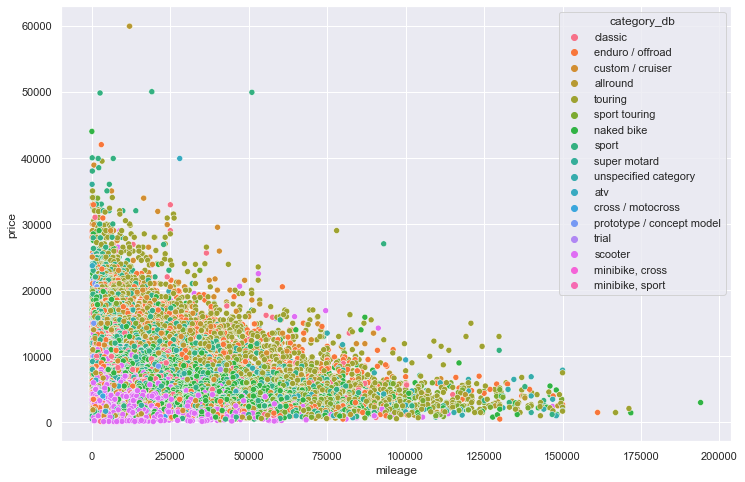

In [14]:
sns.scatterplot(x='mileage', y='price', hue='category_db', data=data);

### vs mileage (km) per engine size

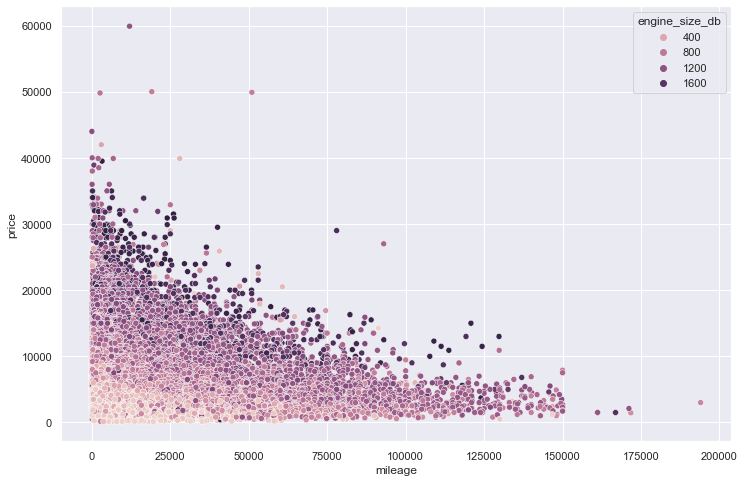

In [16]:
sns.scatterplot(x='mileage', y='price', hue='engine_size_db', data=data);

### vs mileage (km) per power range

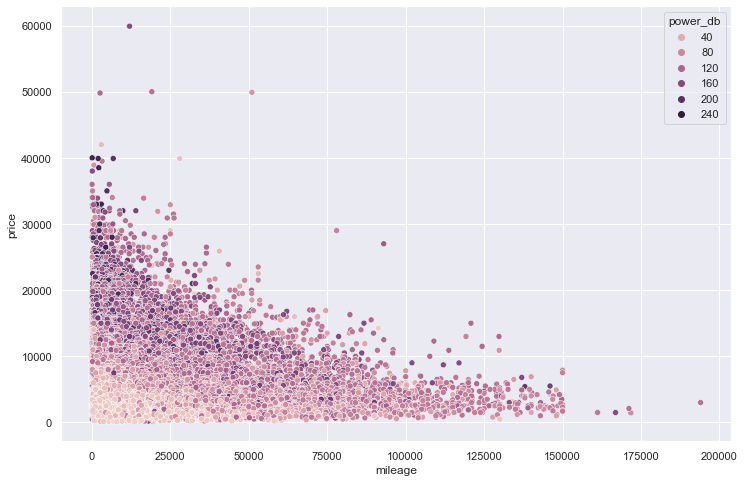

In [17]:
sns.scatterplot(x='mileage', y='price', hue='power_db', data=data);

### vs year of release per category

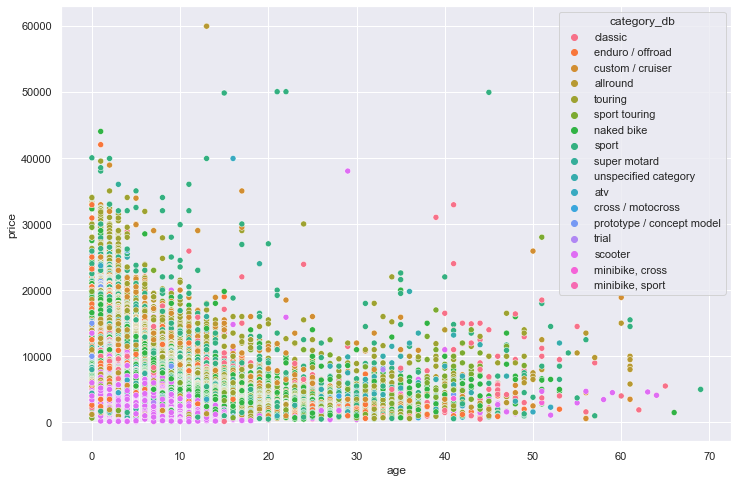

In [18]:
sns.scatterplot(x='age', y='price', hue='category_db',data=data);

### vs year of release per engine size

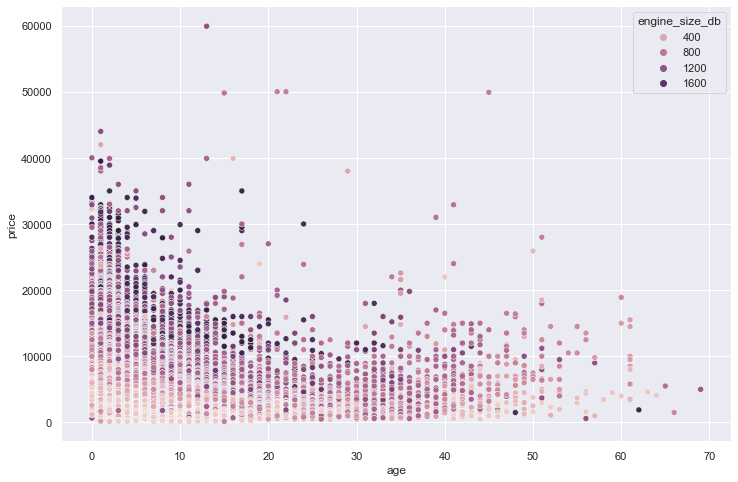

In [20]:
sns.scatterplot(x='age', y='price', hue='engine_size_db', data=data);

### vs km/year

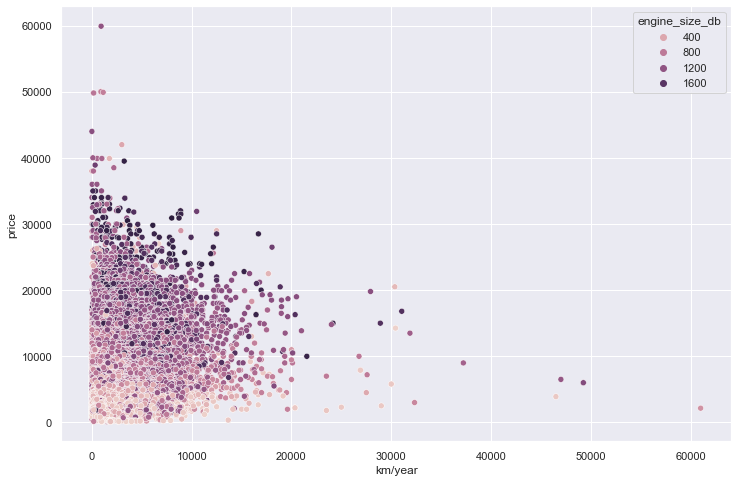

In [21]:
sns.scatterplot(x='km/year', y='price', hue='engine_size_db',data=data);

### Average price per engine size

In [25]:
data.groupby('engine_size_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
engine_size_db,,,
49.0,4037.912281,4173.762740,171
49.1,1996.666667,2716.988529,6
49.2,2195.576923,1521.988125,26
49.3,3239.800000,3918.145276,10
49.4,3692.175000,3929.639358,40
...,...,...,...
1868.0,18411.578947,9572.426492,38
1868.2,7199.000000,NaN,1
1890.0,15425.833333,8369.978232,12


In [26]:
#engine_size_count_threshold = 3
#groupby_engine_size = data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#groupby_engine_size[groupby_engine_size.Count < 4]
#groupby_engine_size

### Average price per category

In [27]:
data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
category_db,,,
allround,8244.558624,5352.854780,1919
atv,8531.200000,7456.522954,85
classic,8209.783080,4072.436193,1383
cross / motocross,7029.698113,4930.303714,212
custom / cruiser,9344.859762,6615.759126,1091
enduro / offroad,9253.605042,6239.082424,2142
"minibike, cross",6667.771429,4168.189317,35
"minibike, sport",1912.500000,85.391256,4
naked bike,6966.708511,4428.638250,5146


In [28]:
category_count_threshold = 200
groupby_category = data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_category = groupby_category[groupby_category .Count < category_count_threshold].index.to_list()
drop_category.append('unspecified category')

In [29]:
data = data[data.category_db.isin(drop_category) == False]

### Average price per brand

In [30]:
data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
brand_db,,,
ace,3040.000000,1767.766953,2
adler,5546.333333,2033.489693,3
adly,11240.000000,353.553391,2
aprilia,8037.824786,5748.573054,234
benelli,5156.187500,2094.412879,112
...,...,...,...
voxan,10895.714286,6239.847373,7
xingyue,5113.000000,5372.012658,5
xmotos,2499.000000,NaN,1


In [31]:
brand_count_threshold = 200
groupby_brand = data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_brand = groupby_brand[groupby_brand.Count < brand_count_threshold].index.to_list()
data = data[data.brand_db.isin(drop_brand) == False]

### Average price per model

In [32]:
data.groupby(['brand_db','model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

Mean          Std  Count
brand_db model_db                                       
aprilia  atlantic125     5810.000000  6297.359235      4
         atlantic500      896.666667   295.014124      3
         caponord1200    7357.500000  2782.135613      8
         classic125      1300.000000          NaN      1
         dorsoduro1200   8445.750000  4887.581340      8
...                              ...          ...    ...
yamaha   yzfr125         4233.233333  3540.502932     30
         yzfr25          4450.000000   353.553391      2
         yzfr3           5442.250000   745.466465      4
         yzfr6           5662.071429  2898.004100     14
         yzfr7          49999.000000     0.000000      2

[1501 rows x 3 columns]

In [33]:
#model_count_threshold = 1
#groupby_model = data.groupby(['model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
#data = data[data.model_db.isin(drop_model) == False]

## Correlation matrix

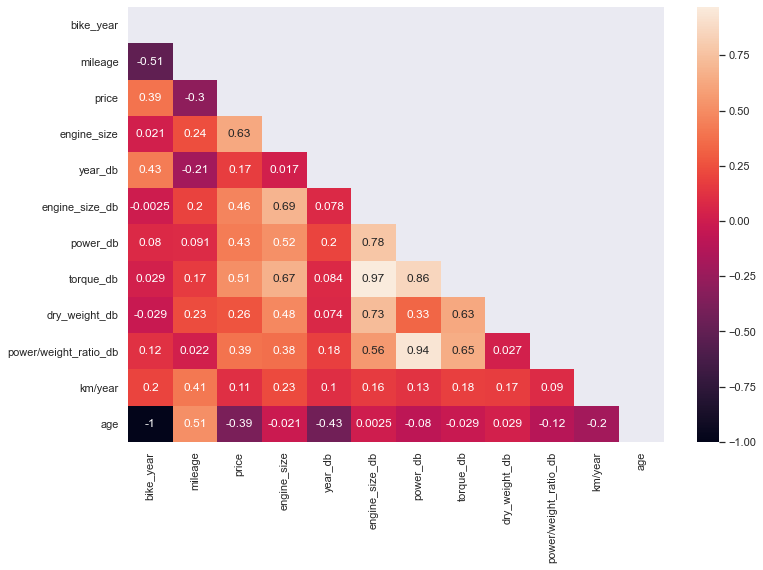

In [34]:
sns.heatmap(data.corr(), annot = True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

# BASELINE

In [35]:
# mean
average_price = data.price.mean()

#rmse
rmse_baseline = np.sqrt(sum((data['price']-average_price)**2)/((data['price'].count())))

print("Average price :", average_price)
print("RMSE Baseline", rmse_baseline )

Average price : 7870.379811986899
RMSE Baseline 5581.5143083099165


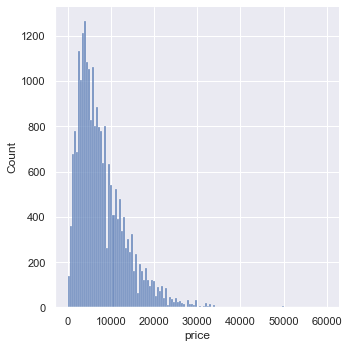

In [36]:
sns.displot(data.price)

# LINEAR REGRESSION

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

## Numerical features (not scaled)

In [ ]:
data_1 = data.copy()
data_1.shape

In [ ]:
features_1 = ['bike_year', 'mileage', 'km/year', 'engine_size']

In [ ]:
for feature in features_1:
    data_1.dropna(subset=[feature],inplace=True)
data_1.shape  

In [ ]:
X = data_1[features_1]
y = data_1['price']

model_1 = LinearRegression()

cv_results = cross_validate(model_1, X, y, cv=5)
cv_results['test_score'].mean()

## Numerical features (not scaled) + brand encoded

In [ ]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

model_2 = LinearRegression()

cv_results = cross_validate(model_2, X, y, cv=5)
cv_results['test_score'].mean()

# KNR

## KNeighborsRegressor - Numerical features (not scaled) + brand encoded

In [ ]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

In [ ]:
model_3 = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(model_3, X, y, cv=5)
cv_results['test_score'].mean()

## KNeighborsRegressor - Numerical features (scaled) + brand encoded

### Brand

### Category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['category_db','brand_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

### Brand and category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

# PIPELINE

In [38]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import set_config

set_config(display='diagram')

## Pipeline Baseline

### Category

In [40]:
data_1=data.copy()[['age','mileage','engine_size','km/year', 'category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year', 'category_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.7896470642724701

### Brand

In [41]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8067149782950885

### Brand & Category

In [42]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db','category_db',]] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8124096333657893

## Pipeline gridsearch

In [43]:
# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe, 
    param_grid={
        'preprocessing__num_transformer__scaler': [StandardScaler()], #MinMaxScaler(), RobustScaler(), 
        'KNeighborsRegressor__n_neighbors': list(range(9,13)),
        #'KNeighborsRegressor__leaf_size': [1,2,3],
        'KNeighborsRegressor__metric': ['euclidean',
                                        'manhattan'],
        'KNeighborsRegressor__weights': ['uniform', 'distance']},
    cv=3,
    scoring=['r2', 'neg_root_mean_squared_error'],
    refit='r2')

grid_search.fit(X_1, y_1)
print("best_params",grid_search.best_params_)
print("best_score",grid_search.best_score_)

best_params {'KNeighborsRegressor__metric': 'euclidean', 'KNeighborsRegressor__n_neighbors': 12, 'KNeighborsRegressor__weights': 'distance', 'preprocessing__num_transformer__scaler': StandardScaler()}
best_score 0.761669309780113


In [44]:
print(grid_search.score(X_1,y_1))
print(final_pipe_trained.score(X_1,y_1))

0.9989449208394313
0.8621262038058657


In [45]:
grid_search.cv_results_

{'mean_fit_time': array([0.01591007, 0.01438657, 0.014323  , 0.01416238, 0.01421134,
        0.01407766, 0.01435987, 0.014124  , 0.01444991, 0.01453114,
        0.01465893, 0.01449601, 0.0149653 , 0.01439699, 0.01472759,
        0.01449299]),
 'std_fit_time': array([1.64169552e-03, 4.97988645e-04, 3.00642772e-04, 1.26349750e-04,
        1.62817411e-04, 1.71606179e-05, 1.95895779e-04, 1.50257602e-04,
        8.48346627e-05, 1.63521082e-05, 2.42084062e-04, 2.61741206e-04,
        4.70771999e-04, 3.54938639e-05, 2.38044764e-04, 1.29928428e-04]),
 'mean_score_time': array([1.83988229, 1.83109045, 1.79290009, 1.78356592, 1.76481938,
        1.78194237, 1.78147936, 1.77325034, 3.05429991, 3.09750263,
        3.10631243, 3.08641466, 3.12774404, 3.11114359, 3.07503406,
        3.10563874]),
 'std_score_time': array([0.03984235, 0.02636151, 0.01040458, 0.02558314, 0.03220249,
        0.04981567, 0.02336575, 0.03640916, 0.03952985, 0.00924351,
        0.01634175, 0.04725747, 0.01353477, 0.045857

## Optimized Pipeline

In [46]:
num_transformer = Pipeline([('scaler', grid_search.best_params_['preprocessing__num_transformer__scaler'])])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and Regression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor(
        #leaf_size=grid_search.best_params_['KNeighborsRegressor__leaf_size'],
        metric=grid_search.best_params_['KNeighborsRegressor__metric'], 
        n_neighbors=grid_search.best_params_['KNeighborsRegressor__n_neighbors'], 
        weights=grid_search.best_params_['KNeighborsRegressor__weights']))])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.832320813438315

In [47]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(final_pipe, X_1, y_1, cv=3, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

r2 0.7722005733335884
RMSE -2584.0273248006706


## Prediction

In [ ]:
X_pred = pd.DataFrame([[10,5000,800,1000,'bmw']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])

In [ ]:
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[4,2347,1200,586,'triumph']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[6,26500,990,4416,'ktm']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )